# <b>Телеком: предсказание разрыва договора абонентом</b>

# Описание проекта

Оператор связи _«ТелеДом»_ хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, _«ТелеДому»_ нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно;

- Интернет. Подключение бывает двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);

- Выделенная линия технической поддержки (Tech Support);

- Облачное хранилище файлов для резервного копирования данных (Online Backup);

- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

Данные хранятся в базе данных `PostgreSQL`. Она состоит из нескольких таблиц:

- `contract` — информация о договорах;

- `personal` — персональные данные клиентов;

- `internet` — информация об интернет-услугах;

- `phone` — информация об услугах телефонии.

### Таблица `telecom.contract`

- `customerID` — ID абонента;

- `BeginDate` — дата начала действия договора;

- `EndDate` — дата окончания действия договора;

- `Type` — тип оплаты: раз в год-два или ежемесячно;

- `PaperlessBilling` — электронный расчётный лист;

- `PaymentMethod` — тип платежа;

- `MonthlyCharges` — расходы за месяц;

- `TotalCharges` — общие расходы абонента.

### Таблица `telecom.personal`

- `customerID` — ID пользователя;

- `gender` — пол;

- `SeniorCitizen` — является ли абонент пенсионером;

- `Partner` — есть ли у абонента супруг или супруга;

- `Dependents` — есть ли у абонента дети.

### Таблица `telecom.internet`

- `customerID` — ID пользователя;

- `InternetService` — тип подключения;

- `OnlineSecurity` — блокировка опасных сайтов;

- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;

- `DeviceProtection` — антивирус;

- `TechSupport` — выделенная линия технической поддержки;

- `StreamingTV` — стриминговое телевидение;

- `StreamingMovies` — каталог фильмов.

### Таблица `telecom.phone`

- `customerID` — ID пользователя;

- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на `1` февраля `2020`.



# Инструкция по выполнению проекта

## Шаг 1. Загрузите данные

Подключитесь к базе данных, используйте для этого код:

```python
db_config = {
  'user': '...', # имя пользователя,
  'pwd': '...',  # пароль,
  'host': '...', # имя хоста
  'port': ...,   # порт подключения,
  'db': '...'    # название базы данных,
}
```

При выполнении проекта задайте константу `RANDOM_STATE`. Её значение будет равно дате начала вашей работы над проектом. Например, если это `1` сентября `2022` года, то

```python
RANDOM_STATE = 10922
```

Используйте эту константу везде, где это необходимо: например, при разделении данных на выборки.

Сначала подключаем необходимые модули, здесь же устанавливаем значение `RANDOM_STATE`:

In [1]:
%pip install psycopg2-binary sqlalchemy lightgbm catboost torch phik scikit-learn==1.2.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2
import sqlalchemy
from sqlalchemy.sql import text
import pandas.io.sql as sqlio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, PrecisionRecallDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader

import phik

RANDOM_STATE = 240423

Подключаемся к базе данных и убеждаемся, что интересующие нас таблицы там присутствуют:

In [3]:
tables_of_interest = ['telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']

url = 'postgresql+psycopg2://...:...:.../...'
engine = sqlalchemy.create_engine(url, connect_args={'sslmode':'require'})

sql = """
    SELECT table_name FROM information_schema.tables;
"""
conn = engine.connect()
query = conn.execute(text(sql))
TABLES = []
for table in query.fetchall():
    table_name = 'telecom.' + table[0]
    if table_name in tables_of_interest:
        TABLES.append(table_name)
        print(table_name)

telecom.personal
telecom.phone
telecom.contract
telecom.internet


Четыре таблицы на месте, можно двигаться дальше.

Посмотрим на количество записей в каждой из таблиц:

In [4]:
for table_name in TABLES:
    print(f'Таблица {table_name}:')
    sql_df = sqlio.read_sql_query(f"SELECT COUNT(*) FROM {table_name};", conn)
    display(sql_df)
    print()

Таблица telecom.personal:


,count
0,7043



Таблица telecom.phone:


,count
0,6362



Таблица telecom.contract:


,count
0,7043



Таблица telecom.internet:


,count
0,5518


Видим, что записи есть во всех таблицах, и записей достаточное количество.

Посмотрим на имена столбцов в таблицах:

In [5]:
for table_name in TABLES:
    print(f'Таблица {table_name}:')
    sql_df = sqlio.read_sql_query(f"SELECT * FROM {table_name} LIMIT 3;", conn)
    display(sql_df)

Таблица telecom.personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Таблица telecom.phone:


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


Таблица telecom.contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


Таблица telecom.internet:


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


Переимнования потребуются, и сделаем их, но сначала перейдём от `SQL` к `Pandas`:

In [6]:
dfs = []

for i in range(len(TABLES)):
    table_name = TABLES[i]
    dfs.append(sqlio.read_sql_query(f"SELECT * FROM {table_name}", conn))
    print(f'Таблица {table_name} переведена в DataFrame')
    
personal_df = dfs[0]
phone_df = dfs[1]
contract_df = dfs[2]
internet_df = dfs[3]

Таблица telecom.personal переведена в DataFrame
Таблица telecom.phone переведена в DataFrame
Таблица telecom.contract переведена в DataFrame
Таблица telecom.internet переведена в DataFrame


In [7]:
personal_df.rename(columns={'customerID': 'customer_id',
                           'SeniorCitizen': 'senior_citizen',
                           'Partner': 'partner',
                           'Dependents': 'dependents'}, inplace=True)

phone_df.columns = phone_df.iloc[0]
phone_df.drop(0, inplace=True)
phone_df.rename(columns={'customerID': 'customer_id',
                        'MultipleLines': 'multiple_lines'}, inplace=True)

contract_df.rename(columns={'customerID': 'customer_id',
                           'BeginDate': 'begin_date',
                           'EndDate': 'end_date',
                           'Type': 'type',
                           'PaperlessBilling': 'paperless_billing',
                           'PaymentMethod': 'payment_method',
                           'MonthlyCharges': 'monthly_charges',
                           'TotalCharges': 'total_charges'}, inplace=True)

internet_df.columns = internet_df.iloc[0]
internet_df.drop(0, inplace=True)
internet_df.rename(columns={'customerID': 'customer_id',
                            'InternetService': 'internet_service',
                            'OnlineSecurity': 'online_security',
                            'OnlineBackup': 'online_backup',
                            'DeviceProtection': 'device_protection',
                            'TechSupport': 'tech_support',
                            'StreamingTV': 'streaming_tv',
                            'StreamingMovies': 'streaming_movies'}, inplace=True)

display(contract_df.head())
display(personal_df.head())
display(internet_df.head())
display(phone_df.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


## Шаг 2. Проведите исследовательский анализ и предобработку данных

### Шаг 2.1 Проанализируйте исходные данные. Проверьте, все ли таблицы содержат данные

Да, мы уже успели убедиться, что все таблицы присутствуют и содержат данные.

### Шаг 2.2 Проверьте, соответствует ли количество таблиц условию задачи

Да, количество таблиц соответствует условию задачи — все `4` таблицы на месте:

- `telecom.contract`;

- `telecom.personal`;

- `telecom.internet`;

- `telecom.phone`.

<a id='EDA'></a>

### Шаг 2.3 Для каждой таблицы:
  
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков;

- Обработайте аномалии с учётом особенностей услуг телекоммуникации.

#### EDA, пропуски, аномалии, распределение признаков - таблица `telecom.contract`

In [8]:
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
display(contract_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1869 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

Видим, что в таблице `7043` записи, но в столбцах `end_date` и `total_charges`есть пропуски. В `end_date` их очень много, так что возможно, что они обозначают, что договор всё ещё действует. В столбце `total_charges` их `11`.

________

Теперь попробуем что-то узнать о распределении числовых признаков:

In [10]:
display(contract_df.describe())

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


##### Расходы за месяц (`monthly_charges`)

Для расходов за месяц (`monthly_charges`) видим, что распределение имеет значения от `18.25` до `118.75`. При этом медиана (`70.35`) превосходит среднее значение `64.761692`, что может говорить о более тяжёлой левой части распределения.

Посмотрим на это распределение графически:

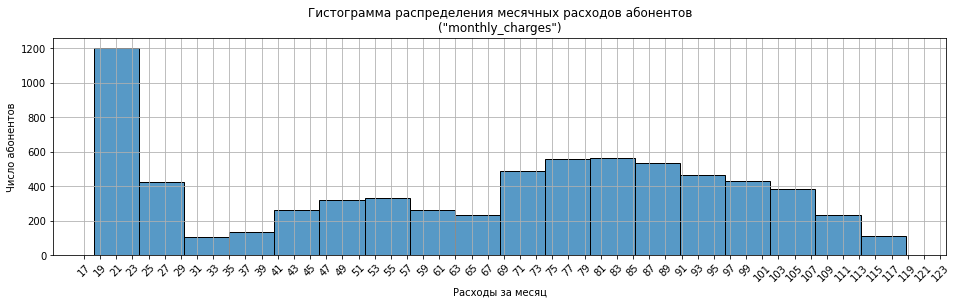

In [11]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.histplot(data=contract_df['monthly_charges'], ax=ax)
_ = ax.grid(True)
_ = ax.set_xticks(range(17, 125, 2))
_ = ax.xaxis.set_tick_params(rotation=45)
_ = ax.set_xlabel('Расходы за месяц')
_ = ax.set_ylabel('Число абонентов')
_ = ax.set_title('Гистограмма распределения месячных расходов абонентов\n("monthly_charges")')

Видим, что мода распределения где-то в районе `21`: видимо, это и стало причиной смещения среднего распределения влево относительно медианы. Выборос и аномалий, на мой взгляд, у данного признака не наблюдается.

____________

##### Общие расходы (`total_charges`)

Что касается признака `total_charges`, то для него диапазон значений значительно шире: от `18.8` до `8684.8`. Медиана равна `1397.475`, а вот среднее значение её заметно ниже - `2283.3`. Это говорит о наличии значений с высоким значением общих расходов, что в общем-то неудивительно, учитывая высокое максимальное значение этого распределения.

Построим гистограмму признака:

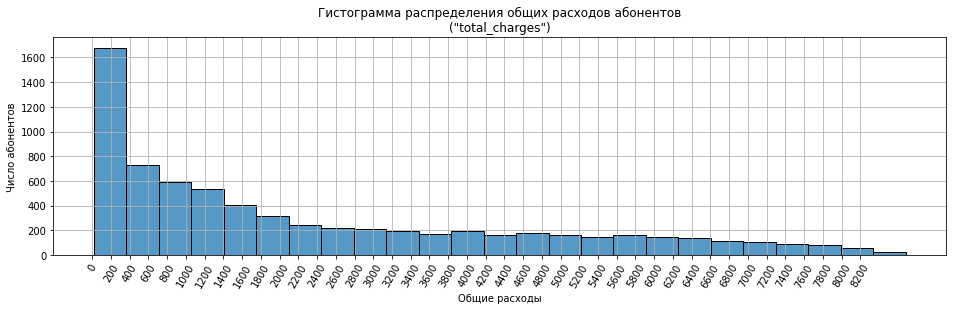

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.histplot(data=contract_df['total_charges'], ax=ax)
_ = ax.grid(True)
_ = ax.set_xticks(range(0, 8400, 200))
_ = ax.xaxis.set_tick_params(rotation=60)
_ = ax.set_xlabel('Общие расходы')
_ = ax.set_ylabel('Число абонентов')
_ = ax.set_title('Гистограмма распределения общих расходов абонентов\n("total_charges")')

Мода распределения у его левого края, и заметен довольно длинный правый хвост. Тем не менее, считать какие-то значения выбросом я бы не стал, если учитывать довольно плавное снижение частоты по мере увеличения месячных расходов.

Теперь нужно решить, что делать с пропусками в этом столбце. Сначала посмотрим на них глазами, ведь их всего `11`:

In [13]:
contract_df[contract_df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Здесь можно заметить, что у всех этих `11` абонентов дата заключения договора - `1` февраля `2020` года, т.е. та самая дата, по которую актуальна информация о договорах. В таком случае, вероятно, мы можем заполнить пропуски в столбце `total_charges` соответствующим значением `monthly_charges`, поскольку общие расходы для таких абонентов и будут равны расхдам месячным:

In [14]:
contract_df['total_charges'].fillna(contract_df['monthly_charges'], inplace=True)

display(contract_df.head(12))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,20.25
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,80.85
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,25.75
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,56.05
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,25.35


Теперь переходим к категориальным признакам.

_________


##### Идентификатор абонента (`customer_id`)

Поле `customer_id` должно представлять собой ID абонента, значит, там не должно быть пропусков. Проверим это:

In [15]:
def print_uniques_count(df, col):
    print(f'Уникальных значений в столбце "customer_id":\n\t{len(df[col].unique())}')

print_uniques_count(contract_df, 'customer_id')

Уникальных значений в столбце "customer_id":
	7043


Видим, что уникальных записей в столбце столько же, сколько всего строк в данной таблице, что подтверждает, что с данным полем всё в порядке.

_______

##### Дата начала действия договора (`begin_date`)

Поле `begin_date` требует приведения к типу данных, представляющему дату:

In [16]:
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])

display(contract_df['begin_date'].to_frame().describe())

/tmp/ipykernel_206/970623776.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(contract_df['begin_date'].to_frame().describe())


,begin_date
count,7043
unique,515
top,2019-03-24 00:00:00
freq,43
first,2018-04-17 00:00:00
last,2020-02-01 00:00:00


Видим, что данные представлены за несколько лет, постараемся учесть это при построении графика распределения:

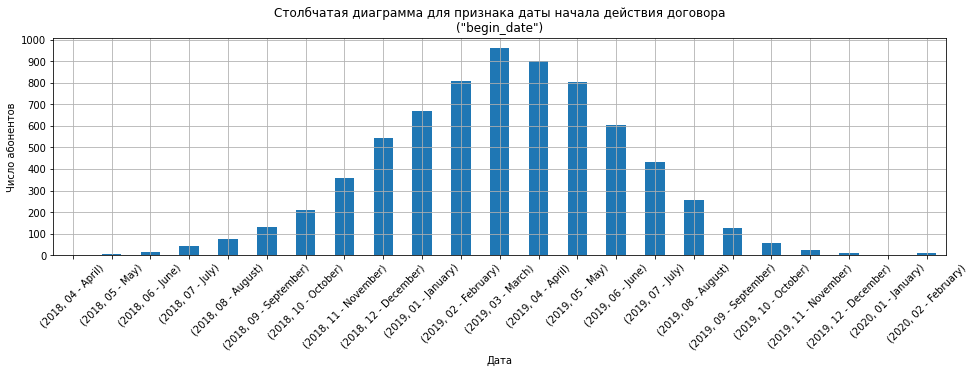

In [17]:
def add_month_column(date_col):
    month_num = str(date_col.month) if date_col.month > 9 else f'0{date_col.month}'
    month_name = date_col.month_name()
    return f'{month_num} - {month_name}'

contract_df['month'] = contract_df['begin_date'].apply(add_month_column)
begin_date_gb = contract_df.groupby([contract_df['begin_date'].dt.year, contract_df['month']])['customer_id'].count()

fig, ax = plt.subplots(figsize=(16, 4))
_ = begin_date_gb.plot(kind='bar', ax=ax)
_ = ax.set_yticks(range(0, 1100, 100))
_ = ax.xaxis.set_tick_params(rotation=45)
_ = ax.grid(True)
_ = ax.set_title('Столбчатая диаграмма для признака даты начала действия договора\n("begin_date")')
_ = ax.set_xlabel('Дата')
_ = ax.set_ylabel('Число абонентов')

contract_df.drop('month', axis=1, inplace=True) # удалим за собой лишний столбец

Видим, что распределение чем-то напоминает нормальное, хотя суть данного признака, на моя взгляд, не имеет такой предрасположенности: какая разница, когда человек заключил договор. Так или иначе, по какой-то причине пик случился в районе февраля `2019` года, причём это не пик, связанный с внедрением какой-то новой услуги - тогда можно было бы ожидать более резкий скачок с левой стороны графика.

____

##### Дата окончания действия договора (`end_date`)

<a id='end_date'></a>

Для признака `end_date` также будет необходимо приведение к типу данных `datetime`. 

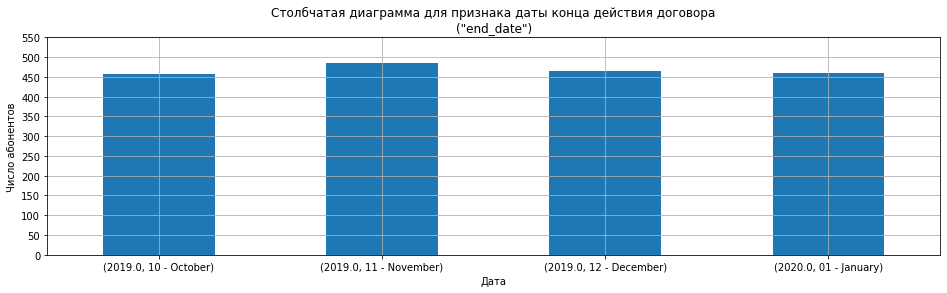

In [18]:
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'])

contract_df['month'] = contract_df['end_date'].apply(add_month_column)
end_date_gb = contract_df.groupby([contract_df['end_date'].dt.year, contract_df['month']])['customer_id'].count()

fig, ax = plt.subplots(figsize=(16, 4))
_ = end_date_gb.plot(kind='bar', ax=ax)
_ = ax.set_yticks(range(0, 600, 50))
_ = ax.xaxis.set_tick_params(rotation=0)
_ = ax.grid(True)
_ = ax.set_title('Столбчатая диаграмма для признака даты конца действия договора\n("end_date")')
_ = ax.set_xlabel('Дата')
_ = ax.set_ylabel('Число абонентов')

contract_df.drop('month', axis=1, inplace=True) # удалим за собой лишний столбецb

Распределение на графие содержит только данные за период с октября `2019` по январь `2020` года. При этом само распределение напоминает равномерное: в среднем ежемесячно прекращали абонентское обслуживание около `450` клиентов.

Также помним, что в данном столбце есть довольно много пропусков.

Кроме того, данный признак для нас будет являться целевым, поэтому нужно принять решение о том, как быть с пропусками.

В силу того, что нам в итоге потребуется модель, которая будет предсказывать, разорвёт ли абонент договор, то можно рассмотреть признак `end_date` в бинарном виде:

- значение `0` будет соответствовать тому, что абонент <u>не будет разрывать договор</u>;

- значение `1` будет соответствовать тому, что абонент <u>разорвёт договор</u>.

За факт того, что абонент разорвал договор, примем все непустые значения в поле `end_date`. А фактом того, что он остался абонентом, будем считать пустые значения в данном поле. Изменения эти сделаем в отдельном поле, назвав его `end_date_target`:

In [19]:
display(contract_df['end_date'].to_frame().describe())

/tmp/ipykernel_206/264880236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(contract_df['end_date'].to_frame().describe())


,end_date
count,1869
unique,4
top,2019-11-01 00:00:00
freq,485
first,2019-10-01 00:00:00
last,2020-01-01 00:00:00


In [20]:
contract_df['end_date_target'] = ~contract_df['end_date'].isna()
display(contract_df.sample(11, random_state=RANDOM_STATE))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target
6856,6120-RJKLU,2019-05-25,NaT,Two year,Yes,Credit card (automatic),79.95,4819.75,False
5383,1682-VCOIO,2019-05-24,NaT,One year,No,Mailed check,20.45,481.10,False
6765,3704-IEAXF,2019-02-07,NaT,Two year,No,Credit card (automatic),53.65,3784.00,False
3098,3307-TLCUD,2019-07-22,NaT,Month-to-month,No,Mailed check,34.40,592.75,False
3994,9512-PHSMG,2019-01-03,NaT,Month-to-month,Yes,Mailed check,20.55,252.75,False
5580,8774-GSBUN,2019-04-17,NaT,Two year,No,Mailed check,25.40,1797.10,False
4450,7339-POGZN,2018-12-25,NaT,Month-to-month,No,Electronic check,50.70,214.55,False
1858,0032-PGELS,2019-02-09,2019-11-01,Month-to-month,No,Bank transfer (automatic),30.50,30.50,True
4440,9402-ORRAH,2019-05-25,NaT,Month-to-month,Yes,Electronic check,91.50,1400.30,False
4299,4323-ELYYB,2019-09-02,NaT,One year,No,Mailed check,20.00,218.55,False


Если мы захотим далее создать признак о длительности договора об абонентском обслуживании, то нам далее можно было бы заполнить пропуски в изначальном столбце `end_date` на максимальную дату среди доступных, тем самым давая понять, что _"по крайней мере до данной даты человек всё ещё являлся абонентом"_:

In [21]:
max_date = max(contract_df['begin_date'].max(), contract_df['end_date'].max())
contract_df['end_date'].fillna(max_date, inplace=True)
display(contract_df.sample(11, random_state=RANDOM_STATE))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target
6856,6120-RJKLU,2019-05-25,2020-02-01,Two year,Yes,Credit card (automatic),79.95,4819.75,False
5383,1682-VCOIO,2019-05-24,2020-02-01,One year,No,Mailed check,20.45,481.10,False
6765,3704-IEAXF,2019-02-07,2020-02-01,Two year,No,Credit card (automatic),53.65,3784.00,False
3098,3307-TLCUD,2019-07-22,2020-02-01,Month-to-month,No,Mailed check,34.40,592.75,False
3994,9512-PHSMG,2019-01-03,2020-02-01,Month-to-month,Yes,Mailed check,20.55,252.75,False
5580,8774-GSBUN,2019-04-17,2020-02-01,Two year,No,Mailed check,25.40,1797.10,False
4450,7339-POGZN,2018-12-25,2020-02-01,Month-to-month,No,Electronic check,50.70,214.55,False
1858,0032-PGELS,2019-02-09,2019-11-01,Month-to-month,No,Bank transfer (automatic),30.50,30.50,True
4440,9402-ORRAH,2019-05-25,2020-02-01,Month-to-month,Yes,Electronic check,91.50,1400.30,False
4299,4323-ELYYB,2019-09-02,2020-02-01,One year,No,Mailed check,20.00,218.55,False


______

##### Тип оплаты (`type`)

Рассмотрим принимаемые значения:

In [22]:
contract_df['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Пропусков в столбце нет, поэтому можо сразу построить график распределения:

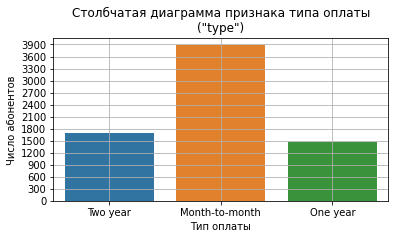

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=contract_df, x='type', ax=ax)
_ = ax.set_yticks(range(0, 4200, 300))
_ = ax.set_title('Столбчатая диаграмма признака типа оплаты\n("type")')
_ = ax.set_xlabel('Тип оплаты')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)

Видно, что абоненты больше предпочитают помесячный тип оплаты. Более неожиданным является то, что тип оплаты «раз в два года» несколько более частотен, чем тип оплаты «раз в год».

_____

##### Электронный расчётный лист (`paperless_billing`)

Смотрим на возможные значения признака:

In [24]:
contract_df['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Поле булево, не имеющее пропусков. Посмотрим на частоты значений на графике:

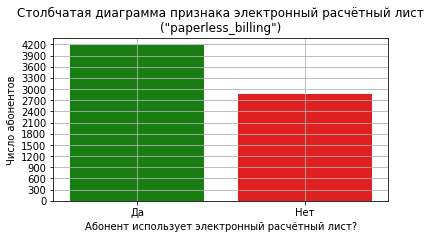

In [25]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=contract_df, x='paperless_billing', palette=['#089000', '#FF0000'], ax=ax)
_ = ax.set_yticks(range(0, 4500, 300))
_ = ax.set_title('Столбчатая диаграмма признака электронный расчётный лист\n("paperless_billing")')
_ = ax.set_xlabel('Абонент использует электронный расчётный лист?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Да'
labels[1] = 'Нет'
_ = ax.set_xticklabels(labels)

_______

##### Тип платежа (`payment_method`)

Данная категория тоже не имеет пропусков, посмотрим на её возможные значения:

In [26]:
contract_df['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Сразу же построим график для распределения:

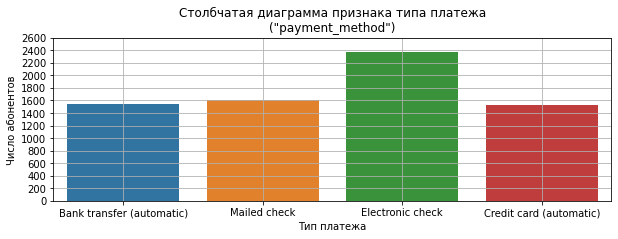

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))
_ = sns.countplot(data=contract_df, x='payment_method', ax=ax)
_ = ax.set_yticks(range(0, 2700, 200))
_ = ax.set_title('Столбчатая диаграмма признака типа платежа\n("payment_method")')
_ = ax.set_xlabel('Тип платежа')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)

Видим, что наибольшей популярностью пользуется электронный чек, прочие категории примерно равны по частоте.

____

#### EDA, пропуски, аномалии, распределение признаков - таблица `personal`

Смотрим на шапку, затем на типы данных и пропуски:

In [28]:
display(personal_df.head())
display(personal_df.info())

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Пропусков нет, а все столбцы, судя по всему, категориальные. Изучим их подробнее.

______

##### Идентификатор абонента (`customer_id`)

Как и в случае таблицы `contract`, представляет ID абонента:

In [29]:
print_uniques_count(personal_df, 'customer_id')

Уникальных значений в столбце "customer_id":
	7043


_________

##### Пол абонента (`gender`)

Здесь мы ожидаем увидеть значения «мужской» и «женский»:

In [30]:
personal_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

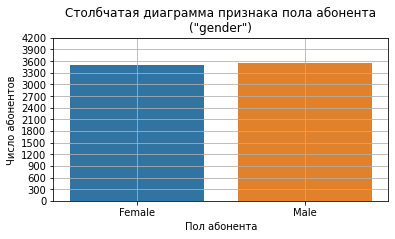

In [31]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=personal_df, x='gender', ax=ax)
_ = ax.set_yticks(range(0, 4500, 300))
_ = ax.set_title('Столбчатая диаграмма признака пола абонента\n("gender")')
_ = ax.set_xlabel('Пол абонента')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)

Всё действительно так, мужчин и женщин оказалось примерно поровну. Из-за тривиальности данного признака обойдёмся без его графического представления.

_______

##### Является ли абонент пенсионером (`senior_citizen`)

Несмотря на численное представление, по своей сути это поле является булевым флагом.

Убедимся в этом, попутно изменяя тип этого столбца:

In [32]:
display(personal_df['senior_citizen'].value_counts())
personal_df['senior_citizen'] = personal_df['senior_citizen'].apply(lambda x: 'No' if x == 0 else 'Yes' if x == 1 else x)
display(personal_df['senior_citizen'].value_counts())

0    5901
1    1142
Name: senior_citizen, dtype: int64

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

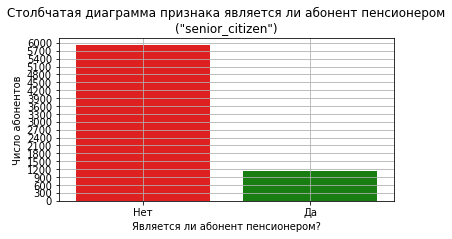

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=personal_df, x='senior_citizen', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 6300, 300))
_ = ax.set_title('Столбчатая диаграмма признака является ли абонент пенсионером\n("senior_citizen")')
_ = ax.set_xlabel('Является ли абонент пенсионером?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)



_______

##### Есть ли у абонента супруг (`partner`)

Поле `partner` должно нам сообщить о том, есть ли у абонента супруг или супруга:

In [34]:
personal_df['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

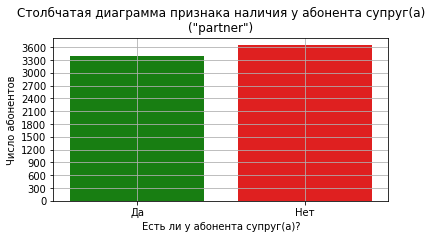

In [35]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=personal_df, x='partner', palette=['#089000', '#FF0000'], ax=ax)
_ = ax.set_yticks(range(0, 3800, 300))
_ = ax.set_title('Столбчатая диаграмма признака наличия у абонента супруг(а)\n("partner")')
_ = ax.set_xlabel('Есть ли у абонента супруг(а)?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Да'
labels[1] = 'Нет'
_ = ax.set_xticklabels(labels)

Видим, что примерно половина абонентов имеют супруга или супругу.

______

##### Есть ли у абонента дети (`dependents`)

Поле `dependents` представляет информацию о наличии у абонента детей:

In [36]:
personal_df['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

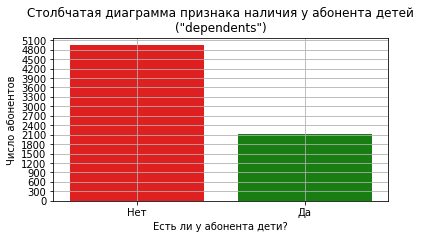

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=personal_df, x='dependents', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 5300, 300))
_ = ax.set_title('Столбчатая диаграмма признака наличия у абонента детей\n("dependents")')
_ = ax.set_xlabel('Есть ли у абонента дети?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Большинство абонентов оператора не имеет детей.

_______

#### EDA, пропуски, аномалии, распределение признаков - таблица `telecom.internet`

Как и ранее, помотрим на шапку, затем на типы данных и пропуски:

In [38]:
display(internet_df.head())
display(internet_df.info())

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


None

Пропусков, судя по всему нет, хотя значений заметно меньше, чем в предыдущих таблицах. Все столбцы, судя по шапке таблицы, являются категориальными, причём все за исключением столбца `internet_service` представляют собой булевы флаги.

_____

##### Идентификатор абонента (`customer_id`)

ID пользователя — уже привычное и является уникальным и в этой таблице:

In [39]:
print_uniques_count(internet_df, 'customer_id')

Уникальных значений в столбце "customer_id":
	5517


_______

##### Тип подключения (`internet_service`)

Этот признак действительно является категориальным, в чём можно убедиться ниже:

In [40]:
internet_df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

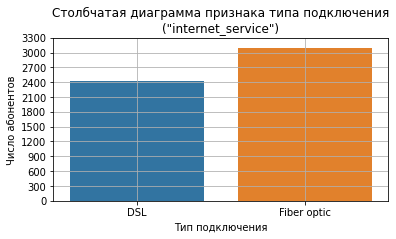

In [41]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='internet_service', ax=ax)
_ = ax.set_yticks(range(0, 3500, 300))
_ = ax.set_title('Столбчатая диаграмма признака типа подключения\n("internet_service")')
_ = ax.set_xlabel('Тип подключения')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)

Видим, что чуть больше половины абонентов используют выделенную линию, и чуть меньше половины — технологию DSL.

_____

##### Блокировка опасных сайтов (`online_security`)

Этот признак, судя по всему, сообщает о том, использует ли абонент услугу по блокировке опасных сайтов:

In [42]:
internet_df['online_security'].value_counts()

No     3498
Yes    2019
Name: online_security, dtype: int64

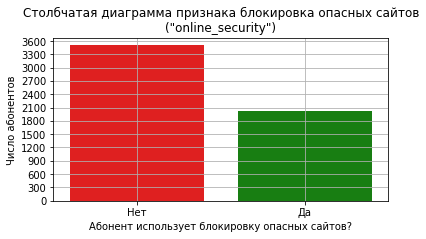

In [43]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='online_security', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3800, 300))
_ = ax.set_title('Столбчатая диаграмма признака блокировка опасных сайтов\n("online_security")')
_ = ax.set_xlabel('Абонент использует блокировку опасных сайтов?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

И большинство абонентов, как можно видеть, не пользуются данной блокировкой.

____

##### Использование облачного хранилища (`online_backup`)


In [44]:
internet_df['online_backup'].value_counts()

No     3088
Yes    2429
Name: online_backup, dtype: int64

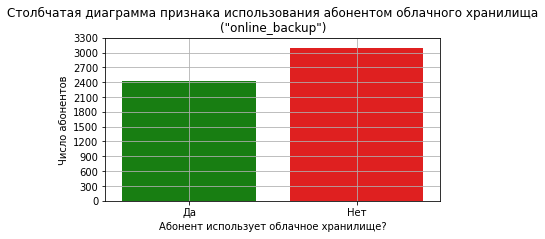

In [45]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='online_backup', palette=['#089000', '#FF0000'], ax=ax)
_ = ax.set_yticks(range(0, 3500, 300))
_ = ax.set_title('Столбчатая диаграмма признака использования абонентом облачного хранилища\n("online_backup")')
_ = ax.set_xlabel('Абонент использует облачное хранилище?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Да'
labels[1] = 'Нет'
_ = ax.set_xticklabels(labels)

И большинство абонентов им всё же не пользуется.

_____

##### Пользуется ли абонент антивирусом (`device_protection`)

In [46]:
internet_df['device_protection'].value_counts()

No     3095
Yes    2422
Name: device_protection, dtype: int64

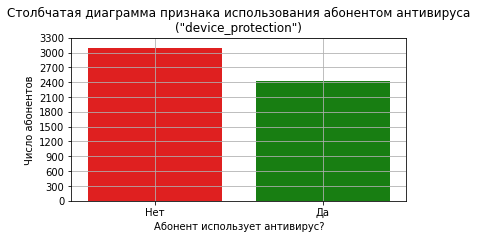

In [47]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='device_protection', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3500, 300))
_ = ax.set_title('Столбчатая диаграмма признака использования абонентом антивируса\n("device_protection")')
_ = ax.set_xlabel('Абонент использует антивирус?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Здесь схожая пропорция с признаком об использовании облачного хранилища данных: большинство им пренебрегает.

_____

##### Выделенная линия технической поддержки (`tech_support`)

In [48]:
internet_df['tech_support'].value_counts()

No     3473
Yes    2044
Name: tech_support, dtype: int64

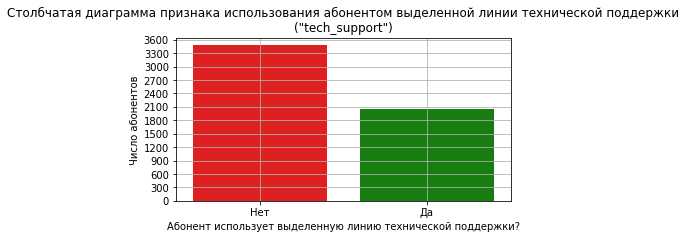

In [49]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='tech_support', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3800, 300))
_ = ax.set_title('Столбчатая диаграмма признака использования абонентом выделенной линии технической поддержки\n("tech_support")')
_ = ax.set_xlabel('Абонент использует выделенную линию технической поддержки?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Удивительно, но аж у более чем двух тысяч абонентов есть доступ к выделенной линии техподдежрки.

______

##### Стриминговое телевидение (`streaming_tv`)

In [50]:
internet_df['streaming_tv'].value_counts()

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

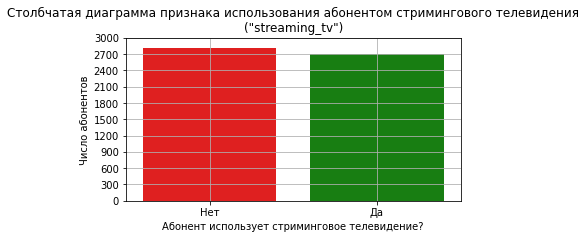

In [51]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='streaming_tv', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3300, 300))
_ = ax.set_title('Столбчатая диаграмма признака использования абонентом стримингового телевидения\n("streaming_tv")')
_ = ax.set_xlabel('Абонент использует стриминговое телевидение?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Здесь наблюдается почти полное равенство: половина абонентов использует стриминговое телевидение, а половина — нет.

____

##### Каталог фильмов (`streaming_movies`)

In [52]:
internet_df['streaming_movies'].value_counts()

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

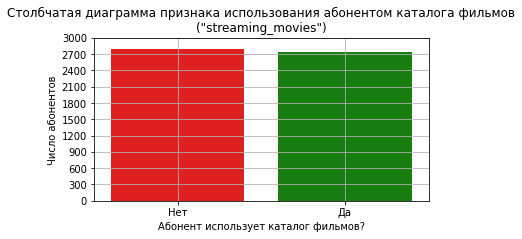

In [53]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=internet_df, x='streaming_movies', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3300, 300))
_ = ax.set_title('Столбчатая диаграмма признака использования абонентом каталога фильмов\n("streaming_movies")')
_ = ax.set_xlabel('Абонент использует каталог фильмов?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Ситуация почти совершенно аналогична ситуации с признаком `streaming_tv`.

____

#### EDA, пропуски, аномалии, распределение признаков - таблица `telecom.phone`

Маленькая таблица всего из двух полей. Смотрим на шапку, типы данных и пропуски:

In [54]:
display(phone_df.head())
display(phone_df.info())

,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


None

Видим, что пропусков вновь нет, переходим к столбцам.

________

##### Идентификатор абонента (`customer_id`)

Как и ранее, проверим его уникальность:

In [55]:
print_uniques_count(phone_df, 'customer_id')

Уникальных значений в столбце "customer_id":
	6361


Поле `customer_id` содержит уникальные значения, как и полагается.

_______

##### Абонент подключен к нескольким телефонным линиям (`multiple_lines`)

Данный признак говорит о том, имеет ли место у абонента подключение телефона к нескольким линиям одновременно:

In [56]:
phone_df['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

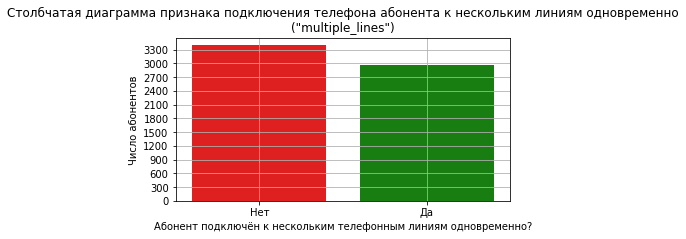

In [57]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=phone_df, x='multiple_lines', palette=['#FF0000', '#089000'], ax=ax)
_ = ax.set_yticks(range(0, 3500, 300))
_ = ax.set_title('Столбчатая диаграмма признака подключения телефона абонента к нескольким линиям одновременно\n("multiple_lines")')
_ = ax.set_xlabel('Абонент подключён к нескольким телефонным линиям одновременно?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Никаких аномалий не видно, признак имеет булево представление, и большая часть абонентов не имеет одновременного подключения к нескольким линиям.

____________

На всякий случай проверим, что пропуски в таблицах отсутствуют:

In [58]:
def print_na_values_count(df, table_name):
    print(f'Число пропусков в таблице "{table_name}":\n\t{df.isna().sum().sum()}')

print_na_values_count(contract_df, 'contract_df')
print_na_values_count(personal_df, 'personal_df')
print_na_values_count(internet_df, 'internet_df')
print_na_values_count(phone_df, 'phone_df')

Число пропусков в таблице "contract_df":
	0
Число пропусков в таблице "personal_df":
	0
Число пропусков в таблице "internet_df":
	0
Число пропусков в таблице "phone_df":
	0


Пропусков действительно нет, будет двигаться дальше.

### Шаг 2.4 Объедините таблицы по ID клиента

Каждому клиенту должно соответствовать одно наблюдение. При объединении учитывайте особенности услуг телекоммуникации

In [59]:
# Объединяемся, делая OUTER-слияние по полю 'customer_id'

united_df = contract_df.merge(personal_df, on=['customer_id'], how='outer')
united_df = united_df.merge(internet_df, on=['customer_id'], how='outer')
united_df = united_df.merge(phone_df, on=['customer_id'], how='outer')

print(list(united_df.columns))
print()
print(f'united_df.shape={united_df.shape}')
print()
display(united_df.head())

['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'end_date_target', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

united_df.shape=(7043, 21)



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,False,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,False,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,False,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


### Шаг 2.5 Попробуйте сгенерировать новые признаки, которые могут пригодится при обучении

Например, рассчитайте длительность контракта абонента.

Добавим новое поле с длительностью контракта (в днях):

In [60]:
united_df['duration'] = united_df['end_date'] - united_df['begin_date']
united_df['duration'] = united_df['duration'].dt.days.astype(float)

display(united_df[['begin_date', 'end_date', 'duration', 'total_charges']].head(10))

,begin_date,end_date,duration,total_charges
0,2020-02-01,2020-02-01,0.0,52.55
1,2020-02-01,2020-02-01,0.0,20.25
2,2018-08-09,2019-12-01,479.0,108.15
3,2020-02-01,2020-02-01,0.0,80.85
4,2019-01-26,2019-11-01,279.0,151.65
5,2018-12-26,2019-11-01,310.0,820.50
6,2020-02-01,2020-02-01,0.0,25.75
7,2020-02-01,2020-02-01,0.0,56.05
8,2019-04-27,2019-11-01,188.0,3046.05
9,2020-02-01,2020-02-01,0.0,25.35


Теперь добавим ещё один новый признак поле, который будет представлять затраты клиента по абонентскому обслуживанию в день (как частное от деления длительности контракта абонента в днях на общие затраты).

Если абонент только заключил договор, т.е. для него `duration == 0`, то будем считать его затраты в день равными общим затратам:

In [61]:
def set_daily_charges(row):
    if row['duration'] == 0:
        return row['total_charges']
    return row['total_charges'] / row['duration']    

united_df['daily_charges'] = united_df.apply(set_daily_charges, axis=1)

display(united_df[['begin_date', 'end_date', 'duration', 'daily_charges', 'total_charges', 'monthly_charges']].head(10))

,begin_date,end_date,duration,daily_charges,total_charges,monthly_charges
0,2020-02-01,2020-02-01,0.0,52.550000,52.55,52.55
1,2020-02-01,2020-02-01,0.0,20.250000,20.25,20.25
2,2018-08-09,2019-12-01,479.0,0.225783,108.15,53.85
3,2020-02-01,2020-02-01,0.0,80.850000,80.85,80.85
4,2019-01-26,2019-11-01,279.0,0.543548,151.65,70.70
5,2018-12-26,2019-11-01,310.0,2.646774,820.50,99.65
6,2020-02-01,2020-02-01,0.0,25.750000,25.75,25.75
7,2020-02-01,2020-02-01,0.0,56.050000,56.05,56.05
8,2019-04-27,2019-11-01,188.0,16.202394,3046.05,104.80
9,2020-02-01,2020-02-01,0.0,25.350000,25.35,25.35


### Шаг 2.6 Выделите в целевую переменную признак `EndDate`

Бинарная целевая переменная [уже была сформирована](#end_date) - `end_date_target`.

Тут рассмотрим её распределение графически:

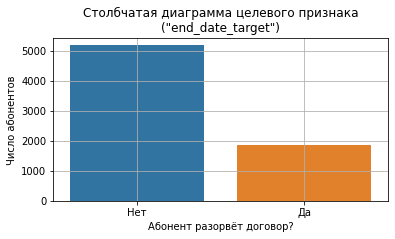

In [62]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = sns.countplot(data=united_df, x='end_date_target', ax=ax)
_ = ax.set_title('Столбчатая диаграмма целевого признака\n("end_date_target")')
_ = ax.set_xlabel('Абонент разорвёт договор?')
_ = ax.set_ylabel('Число абонентов')
_ = ax.grid(True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)

Видим, что желающих сохранить свой договор примерно вдвое больше, чем тех, кто решает расторгнуть свой договор.

Это довольно много, поэтому наш набор данных можно назвать <b>несбалансированным</b>, и нужно будет попробовать как-то компенсировать эту особенность в процессе подготовки итоговой модели предсказания.

### Шаг 2.7 Проведите исследовательский анализ данных объединённой таблицы

При необходимости заполните пропуски и визуализируйте распределение каждого признака.

Признаки были рассмотрены [выше](#EDA).

После выполнения OUTER-слияния можно посмотреть на наличие пропусков в получившейся таблице:

In [63]:
display(united_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   end_date_target    7043 non-null   bool          
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   object        
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

None

Видим, что в столбцах, начиная с `13`-го включительно, идут столбцы с пропусками, причём пропусков много, больше тысячи.

С одной стороны мы могли бы попробовать удалить их, но в результаты этого была бы потеряна очень значительная часть нашего набора данных.

С другой стороны, мы могли бы попробовать их заполнить. Как известно, оператор связи предоставляет не только интернет-связь, но и стационарную телефонную. В таком случае, пропуски начиная с `13`-го столбца могли бы обозначать то, что данный абонент не пользуется интернетом нашего провайдера. Можно также заметить, что пропусков в столбце `internet_service`, который задаёт тип интернет-подключения, ровно столько же, сколько пропусков в столбцах, задающих разнообразные дополнительные интернет-услуги, такие как антивирус или стриминговое телевидение. Это могло бы обозначать следующее: нет интернета, нет и связанных с ним дополнительных услуг.

Исходя из этого, сделаем заполнение пропусков, считая пропуски в столбце `internet_service` связанными со значением `No Internet`. А пропуски во всех прочих столбцах кроме `multiple_lines` - связанными со значением `Not applicable`.

Что касается столбца `multiple_lines`, то проассоциируем пропуски в нём также со значением `Not applicable`, который будет говорить о том, что данный абонент не пользуется стационарной телефонной связью, а значит услуга по подключению телефона к нескольким линиям одновременно для него не может быть осуществлена.

In [64]:
united_df['internet_service'].fillna('No Internet', inplace=True)

united_df['online_security'].fillna('Not applicable', inplace=True)
united_df['online_backup'].fillna('Not applicable', inplace=True)
united_df['device_protection'].fillna('Not applicable', inplace=True)
united_df['tech_support'].fillna('Not applicable', inplace=True)
united_df['streaming_tv'].fillna('Not applicable', inplace=True)
united_df['streaming_movies'].fillna('Not applicable', inplace=True)

united_df['multiple_lines'].fillna('Not applicable', inplace=True)

print_na_values_count(united_df, 'united_df')

Число пропусков в таблице "united_df":
	0


### Шаг 2.8 Визуализируйте соотношение ушедших и оставшихся клиентов для каждого признака

Сначала рассмотрим категориальные признаки.

Напишем вспомогательную функцию для создания визуализаций:

In [65]:
def plot_feature_groups(feature_name):
    gb = united_df.groupby(['end_date_target', feature_name])['customer_id'].count()
    gb = gb.reset_index()

    fig, ax = plt.subplots(figsize=(16, 2))
    _ = sns.barplot(x='end_date_target', y='customer_id', hue=feature_name, data=gb, ax=ax)
    _ = ax.grid(True)
    _ = ax.set_xlabel('Клиент разорвёт договор?')
    _ = ax.set_ylabel('Число абонентов')
    _ = ax.set_title(f'Соотношение ушедших и оставшихся клиентов для признака "{feature_name}"')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Нет (останется)'
    labels[1] = 'Да (уйдёт)'
    _ = ax.set_xticklabels(labels)

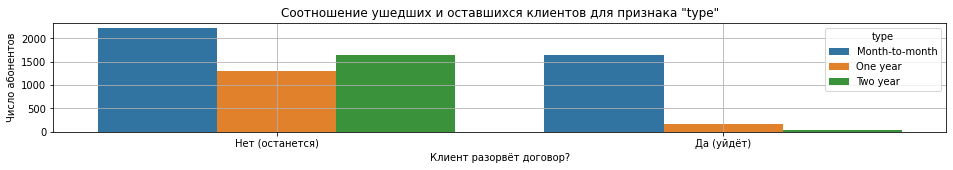

In [66]:
plot_feature_groups('type')

Можно заметить, что для клиентов с помесячной оплатой практически нет разницы относительно разрыва договора: примерное равные доли приходятся и на разорвавших, и на оставшихся абонентов. А вот с теми абонентами, кто платит раз за год или за `2` года, разница существенная. Среди таких абонентов гораздо меньше тех, кто разорвёт договор. Бросается в глаза разница для абонентов с оплатой за `2` года — практически все они останутся клиентами.

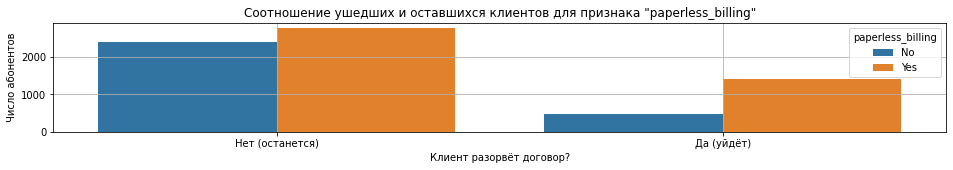

In [67]:
plot_feature_groups('paperless_billing')

Здесь получилась схожая между значениями признака ситуация: и среди пользующихся электронным расчётным листом, и среди не пользующихся им клиентов большая часть останется абонентами.

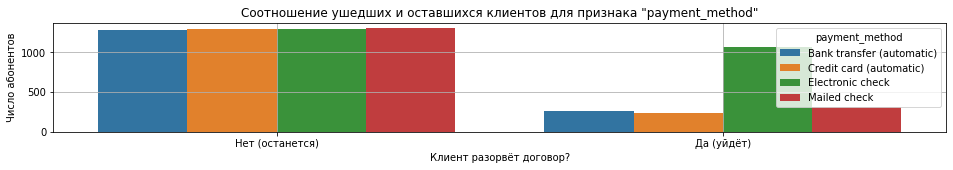

In [68]:
plot_feature_groups('payment_method')

Примечательно, что среди решивших остаться примерно равные доли приходятся на каждый из методов оплаты. Среди тех, кто решил уйти, особенно выделяются абоненты, оплачивающие услуги посредством электронного чека.

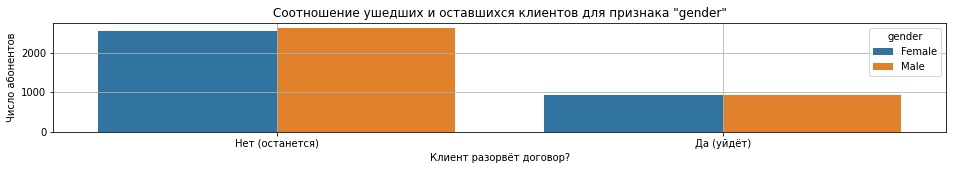

In [69]:
plot_feature_groups('gender')

Доля мужчин и женщин примерно одинакова как среди расторгнувших договор, так и среди оставшихся. Вероятно, данный признак не будет полезен для создаваемой модели прогнозирования.

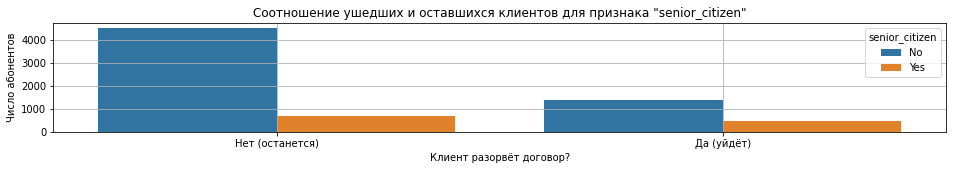

In [70]:
plot_feature_groups('senior_citizen')

Среди пенсионеров примерно равные доли решат уйти и остаться. Среди более молодого поколения большинство не будет разрывать договор: их примерно втрое больше, чем тех, кто решил уйти.

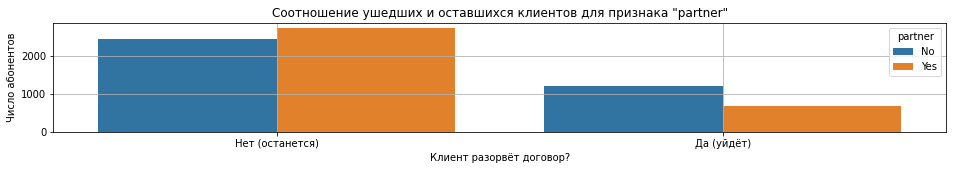

In [71]:
plot_feature_groups('partner')

Здесь заметна разница в более частотной группе для решивших уйти и решивших остаться: среди решивших остаться чуть больше абонентов с супруг(ом|ой) (возможно, такие абоненты более консервативные), а среди решивших расторгнуть договор больше уже тех, кто не имеет второй половинки.

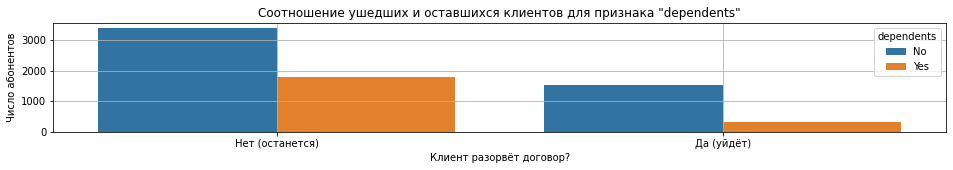

In [72]:
plot_feature_groups('dependents')

Доля абонентов с детьми более выражена для решивших остаться абонентов и достигает почти половины от всех решивших остаться. Среди решивших уйти доля абонентов с детьми заметно ниже, в районе четверти или около того.

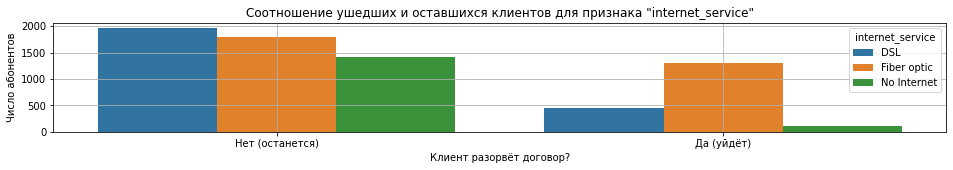

In [73]:
plot_feature_groups('internet_service')

Примечательно, что абоненты, не пользующиеся интернетом, почти поголовно останутся. Пользующиеся `DSL` люди в большей степени тоже останутся абонентами. Это может быть связано с тем, что данная технология уже не настолько распространена, как оптоволокно, и поэтому перед пользователями этой технологии не настолько широк выбор в плане перехода к другим операторам. 

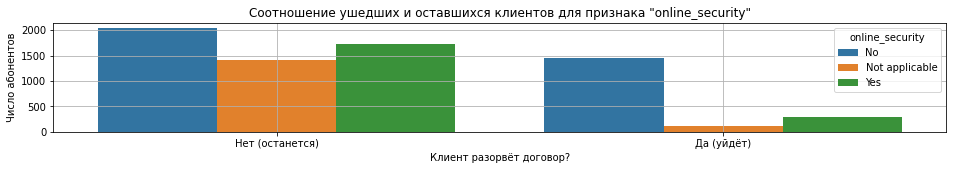

In [74]:
plot_feature_groups('online_security')

Сразу можно отметить, что те, кто используют блокировку опасных сайтов, в большей степени склонны к тому, чтобы не расторгать договор и остаться абонентами.

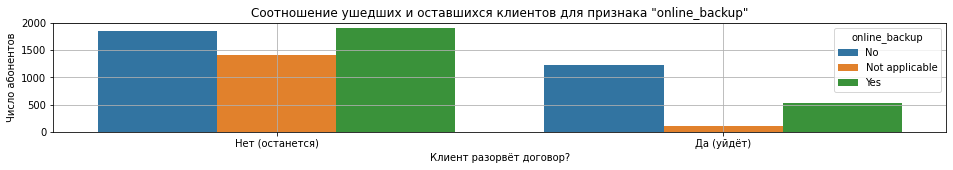

In [75]:
plot_feature_groups('online_backup')

Тех, кто пользуется резервным копированием, более склонны к тому, чтобы остаться: среди всех использующих данную услугу тех, кто останется, примерно втрое больше чем тех, кто уйдёт.

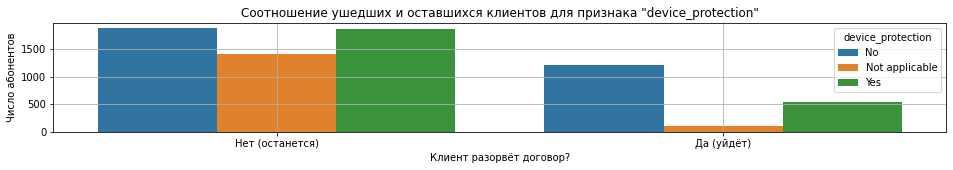

In [76]:
plot_feature_groups('device_protection')

Здесь ситуация очень схожа с предыдущей, разве что среди тех, кто останется, примерно равное количество использующих и не использующих антивирус. Но большая часть из тех, кто пользуется антивирусом, всё же останется.

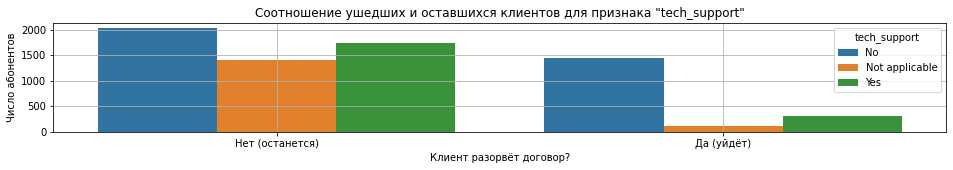

In [77]:
plot_feature_groups('tech_support')

Выделенная линия технической поддержки — заметный фактор, влияющий на решение абонента уйти либо остаться. Большинство из тех, кто ей пользуются, продолжат оставаться абонентами оператора.

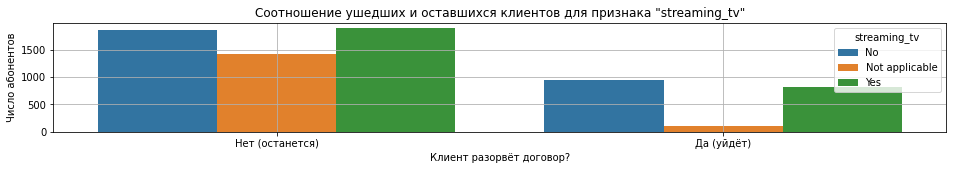

In [78]:
plot_feature_groups('streaming_tv')

Можно заметить примерно равные доли использующих и не использующих стриминговое телевидение как среди остающихся, так и среди уходящих абонентов.

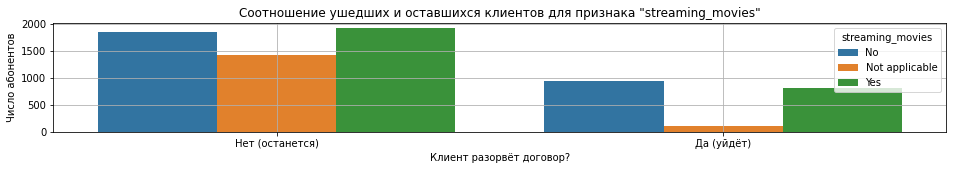

In [79]:
plot_feature_groups('streaming_movies')

Здесь совершенно аналогичная ситуация, как с признаков `streaming_tv`.

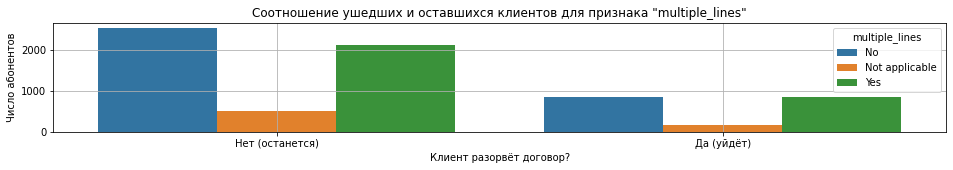

In [80]:
plot_feature_groups('multiple_lines')

Наличие у абонента нескольких телефонных линий одновременно, судя по графику выше, не оказывает большого влияния на решение абонента относительно договора об абонентском обслуживании (разорвать его или нет).

________

У нас осталось ещё несколько признаков, которые не были визуализированы:

- `monthly_charges`;
- `total_charges`;
- `duration`;
- `daily_charges`;
- `begin_date`.

Для их визуализации воспользуемся функцией `pd.qcut()`, а также напишем отдельную функцию для вывода соответствующих графиков:

In [81]:
def plot_qcut_feature_groups(feature_name, bins):
    (bins, labels) = pd.qcut(united_df[feature_name], q=bins, retbins=True)
    
    feature_name_ = f'{feature_name}_qcut'
    united_df[feature_name_] = bins
    
    gb = united_df.groupby(['end_date_target', feature_name_])['customer_id'].count()
    gb = gb.reset_index()

    fig, ax = plt.subplots(figsize=(16, 6))
    _ = sns.barplot(x='end_date_target', y='customer_id', hue=feature_name_, data=gb, palette="Greens_d", ax=ax)
    _ = ax.grid(True)
    _ = ax.set_xlabel('Клиент разорвёт договор?')
    _ = ax.set_ylabel('Число абонентов')
    _ = ax.set_title(f'Соотношение ушедших и оставшихся клиентов для признака "{feature_name_}"')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Нет (останется)'
    labels[1] = 'Да (уйдёт)'
    _ = ax.set_xticklabels(labels)
    
    united_df.drop(feature_name_, axis=1, inplace=True)

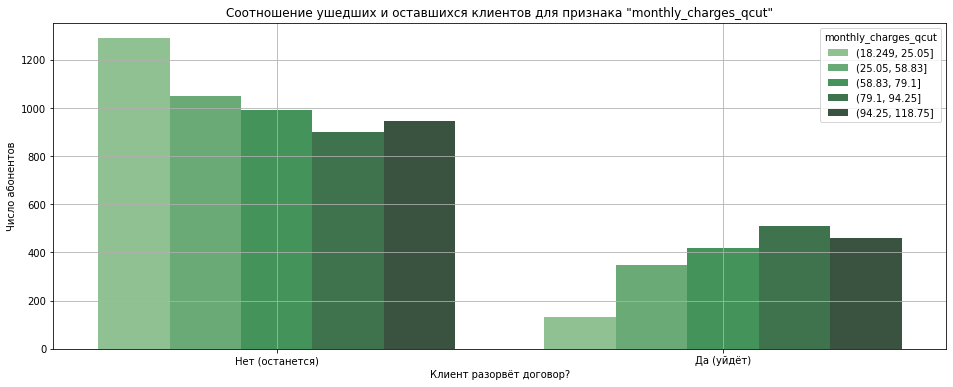

In [82]:
plot_qcut_feature_groups('monthly_charges', bins=5)

Для признака `monthly_charges` мы видим, что доля тех, кто останется, выше чем доля тех, кто уйдёт, причём это справедливо для всех `5` корзин по месячным расходам.

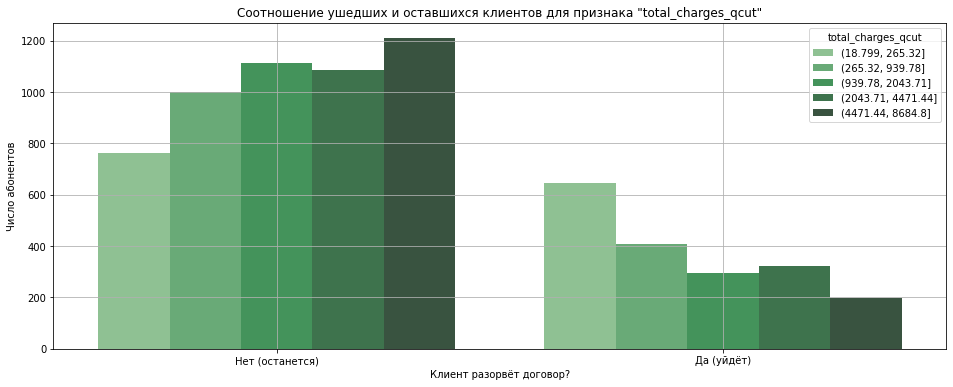

In [83]:
plot_qcut_feature_groups('total_charges', bins=5)

Распределение выглядит несколько ступенчато, причём зеркально. Если для людей с самыми скромными общими затратами доля ушедших почти равна доле решивших остаться, то по мере увеличения общих расходов ситуация меняется. Для абонентов с самыми высокими затратами ситуация другая — здесь доля решивших остаться в несколько раз выше доли тех, кто решил уйти и разорвать договор.

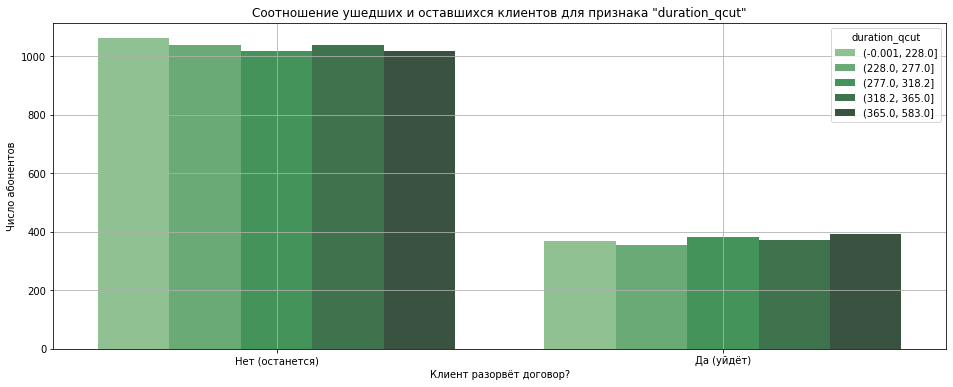

In [84]:
plot_qcut_feature_groups('duration', bins=5)

Для признака `duration` не заметно какого-либо влияния продолжительности действия договора абонентского обслуживания на решение клиента относительно разрыва договора с оператором.

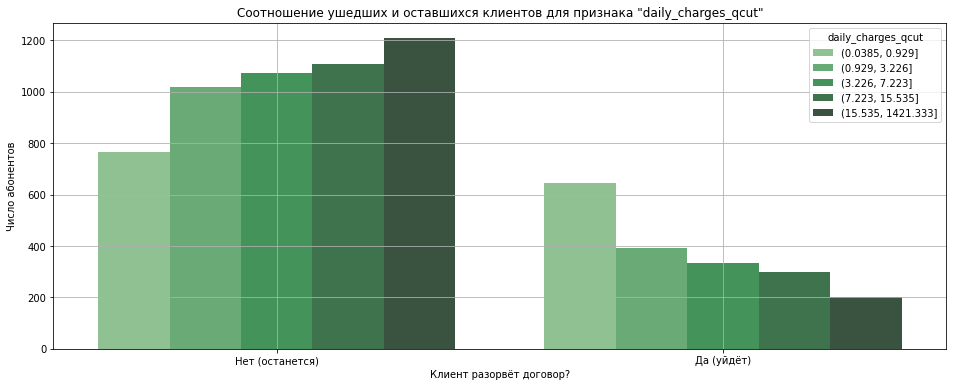

In [85]:
plot_qcut_feature_groups('daily_charges', bins=5)

Здесь ситуация с соотношением очень схожа с ситуацией с признаком `total_charges`, что в некоторой степени ожидаемо, поскольку признак `daily_charges` был сформирован на основе признака `total_charges`.

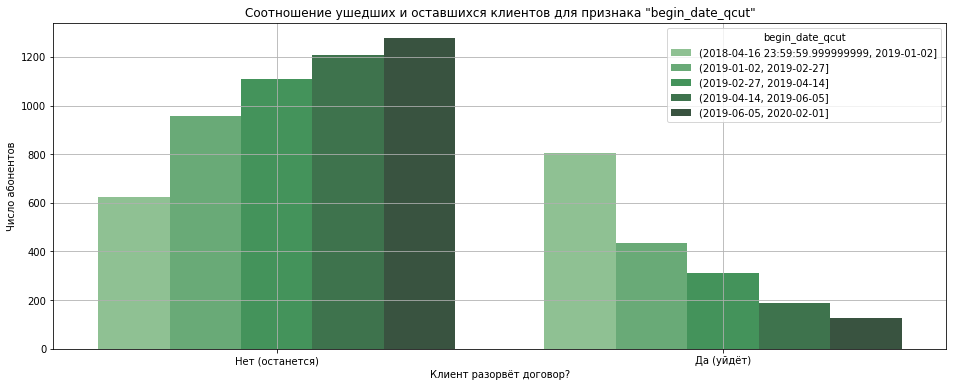

In [86]:
plot_qcut_feature_groups('begin_date', bins=5)

Снова видим соотношение, имеющее ступенчатый характер. Среди абонентов, подключившихся раньше всего, больше тех, кто решил уйти. А среди тех, кто подключился позднее всего, ситуация противоположна: гораздо больше тех, кто решит остаться.

### Шаг 2.9 Проведите корреляционный анализ

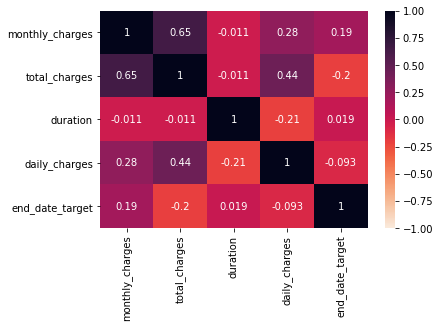

In [87]:
corr_columns = ['begin_date', 'monthly_charges', 'total_charges', 'duration', 'daily_charges', 'end_date_target']

_ = sns.heatmap(united_df[corr_columns].corr(), vmin=-1, vmax=1, annot=True, cmap="rocket_r")

На тепловой карте корреляции можно увидеть высокие значения корреляции между целевым признаком `end_date_target` и признаками:

- `begin_date`;
- `total_charges`;
- `daily_charges`.

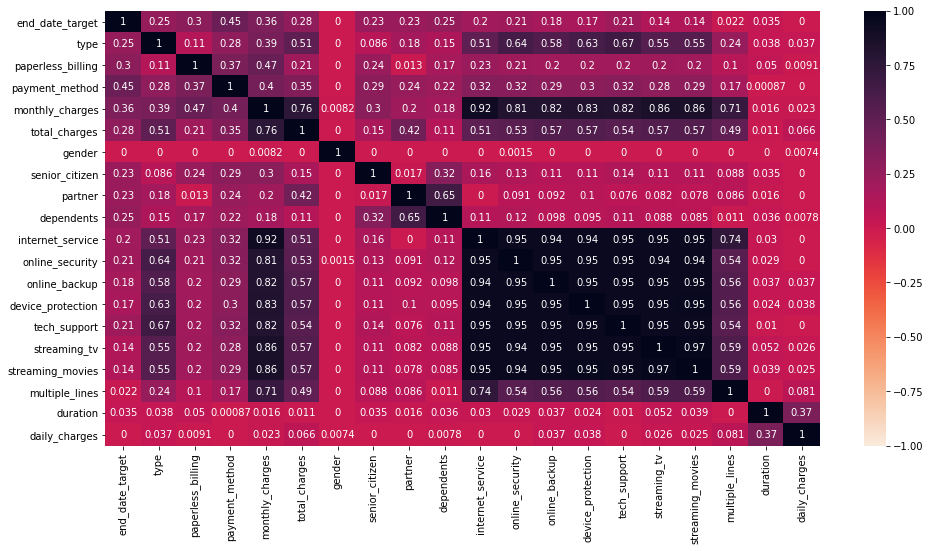

In [88]:
phic_corr_columns = ['end_date_target', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges',
                     'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
                     'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                     'multiple_lines', 'duration', 'daily_charges']
phic_corr = united_df[phic_corr_columns].phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration', 'daily_charges'])

fig, ax = plt.subplots(figsize=(16, 8))
_ = sns.heatmap(phic_corr, vmin=-1, vmax=1, annot=True, cmap="rocket_r", ax=ax)

В лидерах по корреляции для целевого признака `end_date_target` замечаются признаки `payment_method` (`0.45`) и `monthly_charges` (`0.36`).

## Шаг 3. Подготовьте данные для обучения

### Шаг 3.1 Выберете признаки, которые будете использовать

Учитывайте особенности данных и выбранных моделей. Перед вами не стоит задача временных рядов, поэтому не стоит использовать даты как входные признаки модели.

In [89]:
Xy = united_df.copy()

Xy.drop(['customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

Xy.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,daily_charges
0,Two year,Yes,Bank transfer (automatic),52.55,52.55,False,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not applicable,0.0,52.550000
1,Two year,No,Mailed check,20.25,20.25,False,Male,No,No,Yes,No Internet,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,No,0.0,20.250000
2,Month-to-month,Yes,Mailed check,53.85,108.15,True,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,479.0,0.225783


### Шаг 3.2 На случай генерации признака «Длительность контракта абонента»

Если вы сгенерируете новый признак _«Длительность контракта абонента»_, то не используйте его одновременно с любыми другими производными признака `BeginDate` — например, с годом заключения договора. Это приведёт к утечке целевого признака.

Признаков производных от `begin_date` у нас в наборе данных нет, поэтому считаем, что здесь ничего дополнительного нам делать не требуется.

### Шаг 3.3 Разделите данные на тренировочную и тестовую выборки

Используя `test_size = 0.25`.

Сначала выделим входные и целевой признаки в отдельные переменные:

In [90]:
X = Xy.drop('end_date_target', axis=1)
y = Xy['end_date_target']

In [91]:
display(X.head(3))

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,daily_charges
0,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not applicable,0.0,52.550000
1,Two year,No,Mailed check,20.25,20.25,Male,No,No,Yes,No Internet,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,No,0.0,20.250000
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,479.0,0.225783


In [92]:
y = y.astype(int)

Выделим `25%` данных для тестовой части, остальное будет в тренировочной части:

In [93]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

### Шаг 3.4 Подготовьте выборки для обучения

Учитывайте особенности выбранных моделей.

Проведём стандартизацию для числовых признаков, а также _One-Hot-Encoding_ для категориальных.

Сначала для тренировочного набора:

In [94]:
num_features = ['monthly_charges', 'total_charges', 'duration', 'daily_charges']
cat_features = ['type', 'paperless_lilling', 'payment_method', 'gender', 'senior_citizen',
                'partner', 'dependents', 'internet_service', 'online_security',
                'online_backup', 'device_protection', 'tech_support',
                'streaming_tv', 'streaming_movies', 'multiple_lines']

cat_features = ['type', 'payment_method', 'senior_citizen', 'partner', 'internet_service', 'tech_support', 'streaming_tv', 'streaming_movies']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)])

preprocess_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = preprocess_pipeline.fit_transform(X_train_df)
y_train = y_train_df
y_test = y_test_df

encoded_cat_features = preprocess_pipeline['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features)
encoded_cat_features = [x.replace(' ', '_').lower() for x in list(encoded_cat_features)]

feature_names = num_features + list(encoded_cat_features)
X_train = pd.DataFrame(X_train, columns=feature_names)

display(X_train.head())

,monthly_charges,total_charges,duration,daily_charges,type_one_year,type_two_year,payment_method_credit_card_(automatic),payment_method_electronic_check,payment_method_mailed_check,senior_citizen_yes,partner_yes,internet_service_fiber_optic,internet_service_no_internet,tech_support_not_applicable,tech_support_yes,streaming_tv_not_applicable,streaming_tv_yes,streaming_movies_not_applicable,streaming_movies_yes
0,0.985166,-0.877301,-0.893715,-0.697924,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.466165,-0.911162,-0.189128,-0.748670,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.529554,-0.557692,0.670708,-0.546897,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.300488,-0.075243,0.264674,-0.192738,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-1.509929,-0.987432,-1.932683,-0.796867,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


... а затем и для тестового набора:

In [95]:
X_test = preprocess_pipeline.transform(X_test_df)
X_test = pd.DataFrame(X_test, columns=feature_names)

print('X_test.head():')
display(X_test.head())

X_test.head():


,monthly_charges,total_charges,duration,daily_charges,type_one_year,type_two_year,payment_method_credit_card_(automatic),payment_method_electronic_check,payment_method_mailed_check,senior_citizen_yes,partner_yes,internet_service_fiber_optic,internet_service_no_internet,tech_support_not_applicable,tech_support_yes,streaming_tv_not_applicable,streaming_tv_yes,streaming_movies_not_applicable,streaming_movies_yes
0,0.499732,1.112810,-0.547393,0.993472,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,-1.471824,-0.788955,-0.535451,-0.636600,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.371729,0.658809,0.730418,0.180954,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-1.009585,-0.740016,-1.240038,-0.527404,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.468510,-0.889048,1.148394,-0.755851,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


## Шаг 4. Обучите модель

Рассмотрите классы моделей:

- решающее дерево или случайный лес;

- бустинги;

- нейронные сети.

In [96]:
DO_PARAM_SEARCH = False

KFOLD = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

def create_hyperparams_search(search_space):
    pipe = Pipeline([('clf', DummyEstimator())])
    search = RandomizedSearchCV(pipe,
                                param_distributions=search_space,
                                n_jobs=-1,
                                verbose=1,
                                scoring='roc_auc',
                                cv=KFOLD,
                                n_iter=1)
    return search

def run_hyperparams_search(model_name, search):
    search.fit(X_train, y_train)
    best_score = search.best_score_
    best_params = search.best_params_
    print(f'Подбор гиперпараметров для модели "{model_name}":')
    print(f'\tЛучшая оценка на тренировочном наборе: {best_score:.5f}')
    print(f'\tЛучшие параметры: {best_params}')
    return best_score, best_params

def remove_clf_prefix(params):
    params = {k.replace('clf__', ''):v for k,v in params.items()}
    del params['clf']
    return params

### - решающее дерево или случайный лес

In [97]:
%%time

if DO_PARAM_SEARCH:
    tree_search_space = [{
        'clf': [DecisionTreeClassifier()],
    
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],

        'clf__max_depth': [4, 8, 25],
        'clf__min_samples_split': [7, 30, 80],
        'clf__min_samples_leaf': [7, 15, 80],
    }]
else:
    tree_search_space = [{
        'clf': [DecisionTreeClassifier()],
    
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],

        'clf__max_depth': [21],
        'clf__min_samples_split': [100],
        'clf__min_samples_leaf': [90],
    }]  

tree_search = create_hyperparams_search(tree_search_space)
tuned_tree_score, tuned_tree_params = run_hyperparams_search('Дерево решений', tree_search)

tuned_tree = DecisionTreeClassifier(**remove_clf_prefix(tuned_tree_params))
print(f'\ntuned_tree: {tuned_tree}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Подбор гиперпараметров для модели "Дерево решений":
	Лучшая оценка на тренировочном наборе: 0.83468
	Лучшие параметры: {'clf__random_state': 240423, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 90, 'clf__max_depth': 21, 'clf__class_weight': 'balanced', 'clf': DecisionTreeClassifier(class_weight='balanced', max_depth=21,
                       min_samples_leaf=90, min_samples_split=100,
                       random_state=240423)}

tuned_tree: DecisionTreeClassifier(class_weight='balanced', max_depth=21,
                       min_samples_leaf=90, min_samples_split=100,
                       random_state=240423)

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 258 ms


In [98]:
%%time

if DO_PARAM_SEARCH:
    forest_search_space = [{
        'clf': [RandomForestClassifier()],

        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],
        'clf__n_jobs': [-1],
        'clf__bootstrap': [True],

        'clf__max_depth': [3, 21, 150],
        'clf__min_samples_leaf': [2, 15, 90],
        'clf__min_samples_split': [2, 15, 90],
        'clf__n_estimators': [30, 150, 900],
        'clf__max_features': ['sqrt', 'log2', None],
    }]

else:
    forest_search_space = [{
        'clf': [RandomForestClassifier()],

        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],
        'clf__n_jobs': [-1],
        'clf__bootstrap': [True],

        'clf__max_depth': [13],
        'clf__min_samples_leaf': [7],
        'clf__min_samples_split': [50],
        'clf__n_estimators': [400],
        'clf__max_features': ['sqrt'],
    }]


forest_search = create_hyperparams_search(forest_search_space)
tuned_forest_score, tuned_forest_params = run_hyperparams_search('Случайный лес', forest_search)

tuned_forest = RandomForestClassifier(**remove_clf_prefix(tuned_forest_params))
print(f'\ntuned_forest: {tuned_forest}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Подбор гиперпараметров для модели "Случайный лес":
	Лучшая оценка на тренировочном наборе: 0.84297
	Лучшие параметры: {'clf__random_state': 240423, 'clf__n_jobs': -1, 'clf__n_estimators': 400, 'clf__min_samples_split': 50, 'clf__min_samples_leaf': 7, 'clf__max_features': 'sqrt', 'clf__max_depth': 13, 'clf__class_weight': 'balanced', 'clf__bootstrap': True, 'clf': RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=7, min_samples_split=50,
                       n_estimators=400, n_jobs=-1, random_state=240423)}

tuned_forest: RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=7, min_samples_split=50,
                       n_estimators=400, n_jobs=-1, random_state=240423)

CPU times: user 21.7 s, sys: 145 ms, total: 21.8 s
Wall time: 21.8 s


### - бустинги

In [99]:
%%time

if DO_PARAM_SEARCH:
    lgbm_search_space = [{
        'clf': [lgb.LGBMClassifier()],

        'clf__is_unbalance': [True],
        'clf__random_state': [RANDOM_STATE],
        'clf__n_jobs': [-1],

        'clf__boosting_type': ['gbdt', 'dart', 'goss'], 
        'clf__importance_type': ['split', 'gain'], 
        'clf__learning_rate': [0.001, 0.1, 0.15],
        'clf__max_depth': [-1, 2, 11, 21], 
        'clf__n_estimators': [50, 400, 900], 
        'clf__num_leaves': [2, 35, 57],
    }]
else:
    lgbm_search_space = [{
        'clf': [lgb.LGBMClassifier()],

        'clf__is_unbalance': [True],
        'clf__random_state': [RANDOM_STATE],
        'clf__n_jobs': [-1],

        'clf__boosting_type': ['gbdt'], 
        'clf__importance_type': ['gain'], 
        'clf__learning_rate': [0.1],
        'clf__max_depth': [-1],
        'clf__n_estimators': [150], 
        'clf__num_leaves': [3],
    }]  

lgbm_search = create_hyperparams_search(lgbm_search_space)
tuned_lgbm_score, tuned_lgbm_params = run_hyperparams_search('Градиентный бустинг LGBM', lgbm_search)

tuned_lgbm = lgb.LGBMClassifier(**remove_clf_prefix(tuned_lgbm_params))
print(f'\ntuned_lgbm: {tuned_lgbm}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Подбор гиперпараметров для модели "Градиентный бустинг LGBM":
	Лучшая оценка на тренировочном наборе: 0.84200
	Лучшие параметры: {'clf__random_state': 240423, 'clf__num_leaves': 3, 'clf__n_jobs': -1, 'clf__n_estimators': 150, 'clf__max_depth': -1, 'clf__learning_rate': 0.1, 'clf__is_unbalance': True, 'clf__importance_type': 'gain', 'clf__boosting_type': 'gbdt', 'clf': LGBMClassifier(importance_type='gain', is_unbalance=True, n_estimators=150,
               num_leaves=3, random_state=240423)}

tuned_lgbm: LGBMClassifier(importance_type='gain', is_unbalance=True, n_estimators=150,
               num_leaves=3, random_state=240423)

CPU times: user 8min 45s, sys: 14.3 s, total: 9min
Wall time: 9min 4s


In [100]:
%%time

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

if DO_PARAM_SEARCH:
    catboost_search_space = [{
        'clf': [CatBoostClassifier()],

        'clf__verbose': [False],
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weights': [class_weights],

        'clf__iterations': [50, 400,900],
        'clf__learning_rate': [0.01, 0.2, 0.3],
        'clf__depth': [2, 11, 21],
        'clf__l2_leaf_reg': [1, 4, 10],
        'clf__bootstrap_type': ['No', 'Bayesian', 'Bernoulli', 'MVS'],
    }]
else:
    catboost_search_space = [{
        'clf': [CatBoostClassifier()],
        
        'clf__verbose': [False],
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weights': [{0: 0.6838782777597928, 1: 1.8595950704225352}],
        
        'clf__iterations': [500],
        'clf__learning_rate': [0.01],
        'clf__depth': [5],
        'clf__l2_leaf_reg': [10],
        'clf__bootstrap_type': ['MVS'],
    }]

catboost_search = create_hyperparams_search(catboost_search_space)
tuned_catboost_score, tuned_catboost_params = run_hyperparams_search('Градиентный бустинг CatBoost', catboost_search)

tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))
print(f'\ntuned_catboost: {tuned_catboost}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Подбор гиперпараметров для модели "Градиентный бустинг CatBoost":
	Лучшая оценка на тренировочном наборе: 0.84487
	Лучшие параметры: {'clf__verbose': False, 'clf__random_state': 240423, 'clf__learning_rate': 0.01, 'clf__l2_leaf_reg': 10, 'clf__iterations': 500, 'clf__depth': 5, 'clf__class_weights': {0: 0.6838782777597928, 1: 1.8595950704225352}, 'clf__bootstrap_type': 'MVS', 'clf': <catboost.core.CatBoostClassifier object at 0x7f9850aaa610>}

tuned_catboost: <catboost.core.CatBoostClassifier object at 0x7f98502a9e50>

CPU times: user 12.7 s, sys: 657 ms, total: 13.3 s
Wall time: 20.7 s


### - нейронные сети

Используем класс для ранней остановки при отсутствии положительной динамики в обучении:

In [101]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """

    def __init__(self, patience, min_delta):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

Создадим класс для нейронной сети. Используем `2` небольших скрытых слоя по `20` нейронов в каждом:

In [102]:
INPUT_LAYER_SIZE = X_train.shape[1]
HIDDEN_LAYER_1_SIZE = 20
HIDDEN_LAYER_2_SIZE = 20
OUTPUT_LAYER_SIZE = 1
EPOCHS = 200
PATIENCE = 2

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()

        self.layers = torch.nn.Sequential()

        self.layers.add_module('fc1', nn.Linear(in_features=INPUT_LAYER_SIZE, out_features=HIDDEN_LAYER_1_SIZE))
        self.layers.add_module('ac1', nn.ReLU())
        self.layers.add_module('dp1', nn.Dropout(p=0.4))

        self.layers.add_module('fc2', nn.Linear(in_features=HIDDEN_LAYER_1_SIZE, out_features=HIDDEN_LAYER_2_SIZE))
        self.layers.add_module('ac2', nn.ReLU())
        self.layers.add_module('dp2', nn.Dropout(p=0.4))

        self.layers.add_module('final', nn.Linear(in_features=HIDDEN_LAYER_2_SIZE, out_features=OUTPUT_LAYER_SIZE))
        self.layers.add_module('final_ac', nn.Sigmoid())

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)

Напишем функцию для обучения нейронной сети с использованием ранней остановки:

In [103]:
def nn_train_evauate_valid(model, loss, optimizer, x_train, y_train_true, x_valid, y_valid_true):
    early_stopping = CustomEarlyStopping(patience=PATIENCE, min_delta=0.01)

    train_loss = 0.
    train_roc_auc = 0.
    valid_loss = 0.
    valid_roc_auc = 0.
    valid_acc = 0.
    for epoch in range(EPOCHS):
        model.train()

        optimizer.zero_grad()

        y_train_pred = model.forward(x_train)
        train_roc_auc = roc_auc_score(y_train_true, y_train_pred.detach().numpy())

        train_loss = loss(y_train_pred.ravel(), y_train_true)

        train_loss.backward()
        optimizer.step()

        if epoch % 10 != 0:
            continue

        model.eval()
        
        with torch.no_grad():
            y_valid_pred = model.forward(x_valid)
            valid_loss = loss(y_valid_pred.ravel(), y_valid_true)

            valid_roc_auc = roc_auc_score(y_valid_true, y_valid_pred)
            y_valid_pred_cls = np.where(y_valid_pred > 0.5, 1, 0)
            valid_acc = accuracy_score(y_valid_true, y_valid_pred_cls)

            print(f'train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, train_roc_auc={train_roc_auc:.5f}, valid_roc_auc={valid_roc_auc:.5f}, ep.#{epoch}')

        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print('Early Stopping!')
            return valid_roc_auc, valid_acc

    return None

Создаём нашу нейронную сеть и оптимизатор:

In [104]:
nnet_model = NNet()
optimizer = torch.optim.Adam(nnet_model.parameters(), lr=1e-2)

### Шаг 4.1 Найдите лучшую модель для прогноза оттока клиентов

Оцените её качество метрикой `ROC-AUC`. Выберите лучшую модель по значению метрики на кросс-валидации.

In [105]:
# Вспомогательная функция для оценки scikit-learn-эстиматора и получения ROC-AUC и Accuracy
def evaluate_estimator(estimator, x_fold_train, y_fold_train, x_fold_test, y_fold_test):
    estimator.fit(x_fold_train, y_fold_train)
    y_pred_test_proba = estimator.predict_proba(x_fold_test)[:, 1]
    roc_auc = roc_auc_score(y_fold_test, y_pred_test_proba)
    y_pred_test = estimator.predict(x_fold_test)
    acc = accuracy_score(y_fold_test, y_pred_test)
    return roc_auc, acc

In [106]:
tree_roc_aucs = []
tree_accs = []

forest_roc_aucs = []
forest_accs = []

lgbm_roc_aucs = []
lgbm_accs = []

catboost_roc_aucs = []
catboost_accs = []

nn_roc_aucs = []
nn_accs = []

fold_index = 0
for cv_train_idx, cv_test_idx in KFOLD.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.values[cv_train_idx], X_train.values[cv_test_idx]
    y_train_fold, y_test_fold = y_train.values[cv_train_idx], y_train.values[cv_test_idx]

    ################
    # Дерево решений
    ################
    tuned_tree = DecisionTreeClassifier(**remove_clf_prefix(tuned_tree_params))
    roc_auc, acc = evaluate_estimator(tuned_tree, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    tree_roc_aucs.append(roc_auc)
    tree_accs.append(acc)

    ################
    # Случайный лес
    ################
    tuned_forest = RandomForestClassifier(**remove_clf_prefix(tuned_forest_params))
    roc_auc, acc = evaluate_estimator(tuned_forest, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    forest_roc_aucs.append(roc_auc)
    forest_accs.append(acc)
    
    ################
    # LGBM
    ################
    tuned_lgbm = lgb.LGBMClassifier(**remove_clf_prefix(tuned_lgbm_params))
    roc_auc, acc = evaluate_estimator(tuned_lgbm, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    lgbm_roc_aucs.append(roc_auc)
    lgbm_accs.append(acc)
    
    ################
    # CatBoost
    ################
    tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))
    roc_auc, acc = evaluate_estimator(tuned_catboost, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    catboost_roc_aucs.append(roc_auc)
    catboost_accs.append(acc)
    
    ################
    # Нейронная сеть
    ################
    X_train_fold = torch.FloatTensor(X_train_fold)
    X_test_fold = torch.FloatTensor(X_test_fold)
    y_train_fold = torch.FloatTensor(y_train_fold)
    y_test_fold = torch.FloatTensor(y_test_fold)

    nn_fold_roc_auc, nn_fold_acc = nn_train_evauate_valid(nnet_model, nn.BCELoss(), optimizer, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    nn_roc_aucs.append(nn_fold_roc_auc.item())
    nn_accs.append(nn_fold_acc.item())

    fold_index += 1
    print('=' * 80)
    print(f'Окончена обработка фолда #{fold_index}')
    print('=' * 80)

tree_roc_auc = np.mean(tree_roc_aucs)
tree_acc = np.mean(tree_accs)

forest_roc_auc = np.mean(forest_roc_aucs)
forest_acc = np.mean(forest_accs)

lgbm_roc_auc = np.mean(lgbm_roc_aucs)
lgbm_acc = np.mean(lgbm_accs)

catboost_roc_auc = np.mean(catboost_roc_aucs)
catboost_acc = np.mean(catboost_accs)

nn_roc_auc = np.mean(nn_roc_aucs)
nn_acc = np.mean(nn_accs)

train_loss=0.91279, valid_loss=0.77497, train_roc_auc=0.49756, valid_roc_auc=0.52156, ep.#0
train_loss=0.56637, valid_loss=0.50634, train_roc_auc=0.65167, valid_roc_auc=0.77776, ep.#10
train_loss=0.49525, valid_loss=0.45799, train_roc_auc=0.77143, valid_roc_auc=0.82123, ep.#20
train_loss=0.48694, valid_loss=0.44201, train_roc_auc=0.78568, valid_roc_auc=0.82646, ep.#30
train_loss=0.46914, valid_loss=0.44099, train_roc_auc=0.80089, valid_roc_auc=0.82739, ep.#40
INFO: Early stopping counter 1 of 2
train_loss=0.46414, valid_loss=0.43535, train_roc_auc=0.80494, valid_roc_auc=0.83186, ep.#50
INFO: Early stopping counter 2 of 2
INFO: Early stopping
Early Stopping!
Окончена обработка фолда #1
train_loss=0.45872, valid_loss=0.47077, train_roc_auc=0.81117, valid_roc_auc=0.79623, ep.#0
train_loss=0.45383, valid_loss=0.46824, train_roc_auc=0.81700, valid_roc_auc=0.79975, ep.#10
INFO: Early stopping counter 1 of 2
train_loss=0.45107, valid_loss=0.46771, train_roc_auc=0.81730, valid_roc_auc=0.80000,

In [107]:
pd.DataFrame({
    'Имя модели:': [
        'Дерево решений',
        'Случайный лес',
        'LGBM',
        'CatBoost',
        'Нейросеть'],
    'ROC-AUC (кросс-валидация):': [
        f'{tree_roc_auc:.5f}',
        f'{forest_roc_auc:.5f}',
        f'{lgbm_roc_auc:.5f}',
        f'{catboost_roc_auc:.5f}',
        f'{nn_roc_auc:.5f}'],
    'ACCURACY (кросс-валидация):': [
        f'{tree_acc:.5f}',
        f'{forest_acc:.5f}',
        f'{lgbm_acc:.5f}',
        f'{catboost_acc:.5f}',
        f'{nn_acc:.5f}']
}).set_index('Имя модели:')

,ROC-AUC (кросс-валидация):,ACCURACY (кросс-валидация):
Имя модели:,,
Дерево решений,0.83468,0.74461
Случайный лес,0.84297,0.76525
LGBM,0.84200,0.74613
CatBoost,0.84487,0.74897
Нейросеть,0.84079,0.79270


В качестве вывода можно сказать, что по итогам опробованных моделей наилучшее качество показала модель `CatBoost`, поэтому её и выберем как итоговую.

### Шаг 5.1 Проверьте качество лучшей модели на тестовой выборке

Значение метрики `ROC-AUC` должно быть не менее `0.85`. Для интерпретируемости модели дополнительно выведите значение `accuracy`.

На этапе кросс-валидации была выбрана модель `CatBoost`, поэтому на тестовой выборке прогоняем только её:

In [108]:
tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))

tuned_catboost.fit(X_train, y_train)
y_pred_proba_test = tuned_catboost.predict_proba(X_test)[:, 1]
catboost_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

y_pred_test = tuned_catboost.predict(X_test)
catboost_acc = accuracy_score(y_test, y_pred_test)

print('Оценка лучшей модели (CatBoost) на тестовой выборке:')
print(f'\tROC-AUC  : {catboost_roc_auc:.5f}')
print(f'\tAccuracy : {catboost_acc:.5f}')

Оценка лучшей модели (CatBoost) на тестовой выборке:
	ROC-AUC  : 0.85393
	Accuracy : 0.76377


### Шаг 5.2 Постройте матрицу ошибок лучшей модели

Отобразите полноту и точность модели на графике.

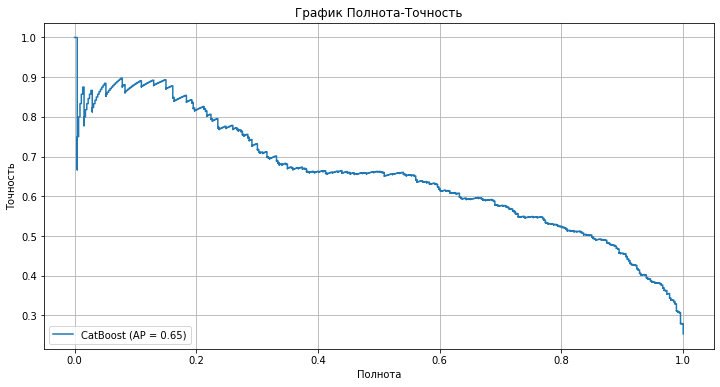

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = PrecisionRecallDisplay.from_estimator(tuned_catboost, X_test, y_test, name="CatBoost", ax=ax)
_ = ax.set_title('График Полнота-Точность')
_ = ax.set_xlabel('Полнота')
_ = ax.set_ylabel('Точность')
_ = ax.grid(True)

Теперь построим матрицу ошибок:

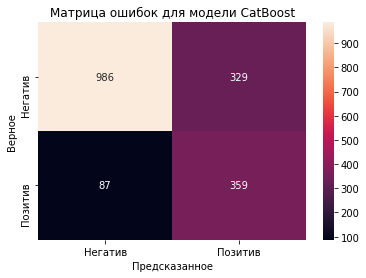

In [110]:
y_pred_test = tuned_catboost.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(6, 4))
_ = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)
_ = ax.set_xlabel('Предсказанное')
_ = ax.xaxis.set_ticklabels(['Негатив', 'Позитив'])
_ = ax.set_ylabel('Верное')
_ = ax.yaxis.set_ticklabels(['Негатив', 'Позитив'])
_ = ax.set_title('Матрица ошибок для модели CatBoost')

Комментарии о содержимом матрицы ошибок будут даны ниже.

### Шаг 5.3 Проанализируйте важность основных входных признаков, влияющих на отток клиентов

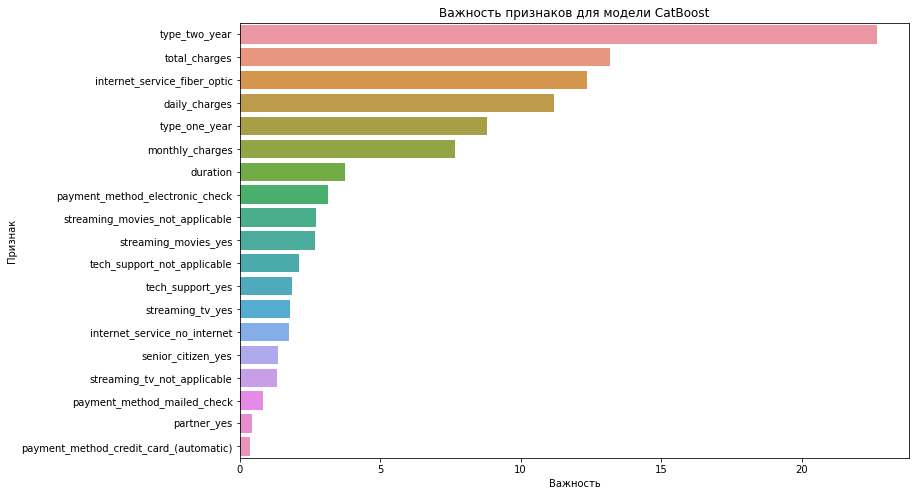

In [111]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    _ = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=ax)
    _ = ax.set_title('Важность признаков для модели CatBoost')
    _ = ax.set_xlabel('Важность')
    _ = ax.set_ylabel('Признак')
    
plot_feature_importance(tuned_catboost.get_feature_importance(), feature_names, 'CATBOOST')

### Шаг 5.4 Для одного из важных входных признаков проведите дополнительное исследование

Покажите график зависимости входного и целевого признаков.

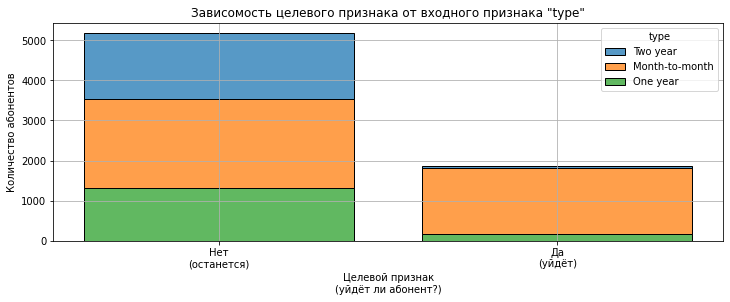

In [112]:
united_df['end_date_target_str'] = np.where(united_df['end_date_target']==1, 'Да\n(уйдёт)', 'Нет\n(останется)')

fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.histplot(united_df, x='end_date_target_str', hue='type', multiple='stack', shrink=.8, ax=ax)
_ = ax.set_title('Зависомость целевого признака от входного признака "type"')
_ = ax.set_xlabel('Целевой признак\n(уйдёт ли абонент?)')
_ = ax.set_ylabel('Количество абонентов')
_ = ax.grid(True)

Признак `type` () является категориальным, поэтому рассмотрим каждое из 3 возможных его значений:

- `Month-to-month` — оранжевый столбец — практически одинаков по размеру для обоих столбцов. Т.е. среди тех абонентов оператора, кто выбирает помесячный тип оплаты, примерно половина решат остаться, а половина — расторгнуть договор. Из-за этого данное значение не выглядит особенно информативным и полезным, тем не менее, в диаграмме важностей признаков CatBoost почему-то именно это значение признака `type` (в его One-Hot представлении) оказалось наиболее значимым;

- `One year` — зелёный столбец — уже показывает существенные различия между долями решивших уйти и решивших остаться. Видим, что подавляющее большинство клиентов решат остаться и не расторгать договор;

- `Two year` — фиолетовый столбец — демонстрирует ещё более значимое различие в долях. Фиолетовая часть правого столбца практически неразличима, так что подавляющее большинство абонентов, оплачивающих услуги раз в два года, останутся с оператором и далее.

## Шаг 6. Сделайте общий вывод по работе

Цель работы заключалась в предсказании оттока клиентов на основе модели для прогноза, при этом рассматривалась задача бинарной классификации на несбалансированном наборе данных. В ходе исследования были опробованы 5 моделей:

- `Дерево решений`;

- `Случайный лес`;

- `Градиентный бустинг LGBM`;

- `Градиентный бустинг CatBoost`;

- `Полносвязная нейронная сеть`.

Наилучшее качество продемонстрировала модей `CatBoost`, поэтому её и можно рекомендовать в качестве итоговой.
Полученные показатели по ROC-AUC и Accuracy следующие:

In [113]:
print(f'\tROC-AUC  : {catboost_roc_auc:.5f}')
print(f'\tAccuracy : {catboost_acc:.5f}')

	ROC-AUC  : 0.85393
	Accuracy : 0.76377


Важнейшими признаками для построенной модели являются следующие:

- `type`;
- `total_charges`;
- `daily_charges`;
- `monthly_charges`;
- `internet_service`.

Несмотря на то, что первым по важности является признак, связанный с типом оплаты (`type`), обращают на себя внимание количественные признаки, связанные с оплатой услуг оператора (`total_charges`). Ещё одним важным категориальным признаком является тип интернет-подключения (либо его отсутствие) — `internet_service`.



Для более детального анализа допускаемых моделью ошибок была построена матрица ошибок. Рассматривая её результаты, стоит отметить значительное количество ошибок `I` рода (`False Positive`) — `329`, когда модель предсказывала, что клиент уйдёт, когда он на самом деле решал остаться абонентом оператора. Доля ошибок `II` рода (`False Negative`) сильно меньше — только `87` экземпляра.